In [1]:
import os
import pandas as pd
import numpy as np
import os
import time

from textwrap import wrap
import urllib3
# from urllib3 import request
import certifi
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import KDTree
from geopy.distance import geodesic

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import ListedColormap


sns.set(context='notebook', style='dark', font_scale=1.5)

PROJ_ROOT = os.path.join(os.pardir)

%load_ext watermark
%watermark -a "Bryan Dickinson" 
%watermark -iv -p scipy,matplotlib,geopy

Bryan Dickinson
pandas     1.1.0
geopandas  0.8.1
seaborn    0.10.1
json       2.0.9
contextily 1.0.0
certifi    2020.06.20
numpy      1.18.5
urllib3    1.24.3
scipy 1.4.1
matplotlib 3.3.0
geopy 2.0.0


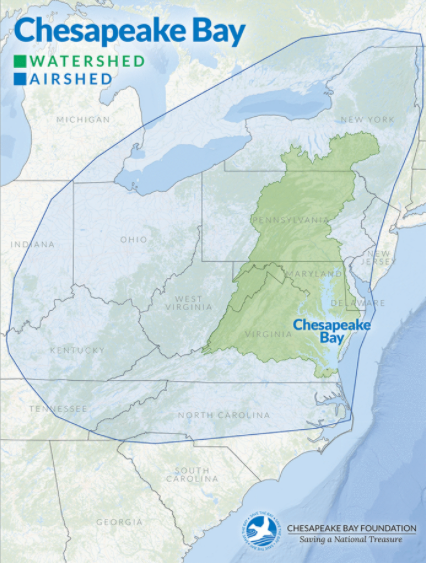

Air pollution sources contribue about one-third of the total nitrogen loads to the Chesapeake Bay. This analysis will import NO2 and join with the original dataset, so that each observation of the original data will have the closest monitoring station's value of NO2. Then will look to determine if there is a correlation between the sample locations in the CMC/CBP recording of total nitrogen and air Nitrogen dioxide (NO2) data from the EPA's Air Quality System (AQS) database.

AQS contains ambient air sample data collected by state, local, tribal, and federal air pollution control agencies from thousands of monitors around the nation. It also contains meteorological data, descriptive information about each monitoring station (including its geographic location and its operator), and information about the quality of the samples.

The Clean Air Act requires that state, local, and tribal air pollution control agencies monitor the air for ambient levels of certain pollutants. This data is reported to the United State Environmental Protection Agency (EPA). The monitoring agencies are required to report the measured data, along with metadata about the site and monitoring equipment and associated quality assurance data to the US EPA’s Air Quality System (AQS). AQS and its predecessors have been accepting and storing this data for more than 40 years and currently contains more than 2 billion measurements.


https://www.cbf.org/about-the-bay/maps/geography/the-chesapeakes-airshed.html
https://www.epa.gov/chesapeake-bay-tmdl/air-pollution-chesapeake-bay-watershed
https://aqs.epa.gov/aqsweb/documents/data_api.htm

## Download import and transform the data

In [2]:
#import api keys from the environment
API_KEY = os.environ.get('API_KEY')
API_EMAIL = os.environ.get('API_EMAIL')

# Using the Air Quality System (AQS) API at https://aqs.epa.gov/aqsweb/documents/data_api.html
# Alterntative is to download daily summaries by year at https://www.epa.gov/outdoor-air-quality-data/download-daily-data

In [3]:
# states ['VA','MD','DE','PA','DC','WV','NY']
state_fips = [51,24,10,42,11,54,36]
years=np.arange(2005, 2021) # years of data that are in the original CMC/CBP dataset
PARAMETER = 42602 # API parameter for NO2
BDATE='0101' # beginning month/day of data collection
EDATE='1231' # ending month/day of data collection
URL='https://aqs.epa.gov/data/api/dailyData/byState?'


In [4]:
# handle certificate verification and SSL warnings
# https://urllib3.readthedocs.io/en/latest/user-guide.html#ssl

http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())

In [5]:
def extract_no_data(st, yr):
    """ A function to download a parmeter from the AQS API from the EPA"""
     #capture time to limit API calls according to the API documentation
    t0 = time.time()
    #create the url for the api call
    url = URL+'email='+API_EMAIL+"&key="+API_KEY+"&param="+str(PARAMETER)+"&bdate="+str(yr)+BDATE+"&edate="+str(yr)+EDATE+"&state="+str(st) 
    
    print('Reqeusting data for ',st, ' ', yr )
    # request the data
    r = http.request('GET', url)
    
    # decode the json data
    data=json.loads(r.data.decode('utf-8'))
    
    #create a dataframe
    df=pd.json_normalize(data,'Data')
    
    #return the dataframe and the call time
    return df, t0

In [6]:
def create_no_df(state_fips=state_fips, years=years):
    """A function to download the EPA parameter data and transform into a dataframe"""
    #create empty dataframe to hold the complete data
    no_df = pd.DataFrame()
    
    #loop through all the combinations of year / state to retrieve the data from the api
    for st in state_fips:
        for yr in years:
            
            
            # retreive the data from the API
            df, t0 = extract_no_data(st, yr)
            # concat the returned dataframe
            no_df = pd.concat([no_df, df])
            
            #capture current time
            t1=time.time()
            
            #sleep if the time requirements have not passed for the next API call
            if t1 - t0 < 5:
                time.sleep(7-(t1 - t0))
            print('Finished importing nitrogen oxide data for ', st,' ', yr)
    
    return no_df # return the dataframe

In [7]:
#download and transform the data into a dataframe
no_df = create_no_df()

In [8]:
# no_df=pd.read_csv(os.path.join(PROJ_ROOT, 
#                          'data',
#                         'processed',
#                          'no_data.csv'))

In [9]:
no_df.shape

(523554, 31)

In [10]:
#take a look at the dataframe
no_df.head(3)

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,51,36,2,42602,1,37.34438,-77.25925,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,25,INSTRUMENTAL - CHEMILUMINESCENCE,Shirley Plantation,"SHIRLEY PLANTATION, ROUTE 5",Virginia,Charles,Not in a city,40060.0,"Richmond, VA",2013-06-11
1,51,36,2,42602,1,37.34438,-77.25925,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,25,INSTRUMENTAL - CHEMILUMINESCENCE,Shirley Plantation,"SHIRLEY PLANTATION, ROUTE 5",Virginia,Charles,Not in a city,40060.0,"Richmond, VA",2013-06-11
2,51,36,2,42602,1,37.34438,-77.25925,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,25,INSTRUMENTAL - CHEMILUMINESCENCE,Shirley Plantation,"SHIRLEY PLANTATION, ROUTE 5",Virginia,Charles,Not in a city,40060.0,"Richmond, VA",2013-06-11


In [11]:
# reset index
no_df.reset_index(drop=True, inplace=True)

In [12]:
# save the nitrogen data that was downloaded
# no_df.to_csv(os.path.join(PROJ_ROOT, 
#                          'data',
#                         'processed',
#                          'no_data.csv'),index=False)

In [13]:
# look at the dataframe, the date_local variable is an object
no_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523554 entries, 0 to 523553
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   state_code           523554 non-null  int64  
 1   county_code          523554 non-null  int64  
 2   site_number          523554 non-null  int64  
 3   parameter_code       523554 non-null  int64  
 4   poc                  523554 non-null  int64  
 5   latitude             523554 non-null  float64
 6   longitude            523554 non-null  float64
 7   datum                523554 non-null  object 
 8   parameter            523554 non-null  object 
 9   sample_duration      523554 non-null  object 
 10  pollutant_standard   523554 non-null  object 
 11  date_local           523554 non-null  object 
 12  units_of_measure     523554 non-null  object 
 13  event_type           523554 non-null  object 
 14  observation_count    523554 non-null  int64  
 15  observation_perce

In [14]:
no_df.describe()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi,method_code,cbsa_code
count,523554.000000,523554.000000,523554.000000,523554.0,523554.000000,523554.000000,523554.000000,523554.000000,523554.000000,523554.000000,523554.00000,523554.000000,523554.000000,523554.000000,513620.000000
mean,39.062221,105.895411,489.728830,42602.0,1.173208,39.918895,-77.120288,23.345607,97.318084,10.991282,21.87490,11.447755,20.493164,123.200556,35787.904521
std,11.270799,171.968734,1203.337704,0.0,0.592184,1.467293,1.856994,2.121904,8.820694,7.949138,13.19272,8.094209,12.494882,135.983043,11135.676399
min,10.000000,1.000000,1.000000,42602.0,1.000000,36.850426,-82.585714,1.000000,4.000000,-1.952174,-0.80000,0.000000,0.000000,25.000000,10900.000000
25%,36.000000,11.000000,8.000000,42602.0,1.000000,38.921847,-78.771530,24.000000,100.000000,5.037500,11.50000,5.000000,10.000000,74.000000,29540.000000
50%,42.000000,49.000000,24.000000,42602.0,1.000000,40.046667,-77.044350,24.000000,100.000000,9.280000,20.60000,8.000000,19.000000,99.000000,38300.000000
75%,42.000000,103.000000,124.000000,42602.0,1.000000,40.736140,-75.623056,24.000000,100.000000,15.130435,30.20000,20.000000,28.000000,99.000000,44300.000000
max,54.000000,760.000000,7003.000000,42602.0,5.000000,44.980577,-73.057540,24.000000,100.000000,84.000000,166.00000,23.000000,113.000000,599.000000,49620.000000


The *arithmetic mean* and *first max value* columns are the values of the monitor recording. Both columns will be captured to compare with the original data. 

It's odd that there are negative values for *first max value* and for the *arithmetic mean*. The 25 percentile shows values above 0, I will leave the values as-is for now for speed of analysis and investigation into these monitoring values. To improve this analysis, investigation into negative values is needed.

## Import the original data

In [15]:
def calc_distance(row):
    """ Function to calculate the geodesic distance between two coordinates in miles"""
    # geodesic distance https://en.wikipedia.org/wiki/Geodesics_on_an_ellipsoid
    
    coords = (row["latitude"],row["longitude"])
    pol_coords=(row['p_lat']),row['p_long']
    
    distance = geodesic(pol_coords, coords).miles
    
    return distance

In [16]:
data_path = os.path.join(PROJ_ROOT, 
                         'data',
                        'processed',
                         'model_data_v2.csv')

# create a dataframe of only the longitude and latitude of the original data
loc_df=pd.read_csv(data_path,usecols=['longitude','latitude'])

## Determine the closest monitoring station & extract NO2 data to the original dataset

In [17]:
allcoord = list(zip(loc_df.latitude,loc_df.longitude))

no_coord = list(zip(no_df[['latitude','longitude']].drop_duplicates().latitude,
                    no_df[['latitude','longitude']].drop_duplicates().longitude))



In [18]:
#read in the existing dataframe with all the data
all_df=pd.read_csv(data_path,parse_dates=['new_date'])

In [19]:
#change the format of the to match the other dataframe
all_df['date'] = all_df.new_date.apply(lambda x: x.strftime("%Y-%m-%d"))

In [20]:
# make a kdtree for the monitoring coordinates, then query it for the CMC/CBP coordinates
tree = KDTree(no_coord)


# query and obtain corresponding NO2 data
noxyid=tree.query(allcoord,k=1)


In [21]:
#investigate the long/lat and distance between two points
print(allcoord[3],no_coord[noxyid[1][3]])

(38.5645, -75.6723) (38.7791, -75.16323)


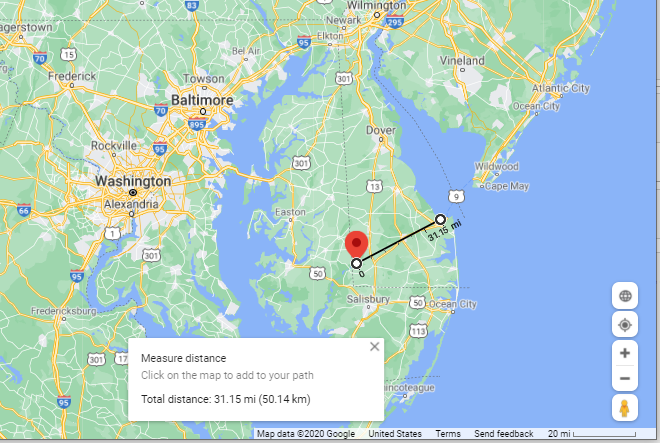
The distance from those two above points is 31 miles. Distance between the sample location and monitoring station will need to be looked at. Wind direction and intensity may affect how correlated these two point values may be, if any.

In [22]:
# add the closest long/lat from the sample site and add to the loc_df
loc_df['p_lat']=loc_df.apply(lambda x: no_coord[noxyid[1][x.name]][0],axis=1)
loc_df['p_long']=loc_df.apply(lambda x:no_coord[noxyid[1][x.name]][1],axis=1)

In [23]:
# calculate the distance between each sample location and it's closest NO2 monitoring station
loc_df['distance'] = loc_df.apply(calc_distance, axis=1)

In [24]:
# take a look at what the maximum distance between two points in the data
loc_df.distance.max()

65.64571279231981

In [25]:
loc_df.shape

(66892, 5)

In [26]:
#concat the closest monitoring location and distance to the original data
#in preparation for merging with the new NO2 data
all_df = pd.concat([all_df, loc_df[['p_lat','p_long','distance']]],axis=1)

In [27]:
#rename the NO2 dataframe columns
no_df.rename(columns={'longitude':'no_long', 'latitude':'no_lat'},inplace=True)

In [28]:
#merge the original data with the NO2 data

merged_df=pd.merge( all_df,
         no_df[['no_lat','no_long','date_local','arithmetic_mean','first_max_value']].drop_duplicates(),
         left_on=['p_lat','p_long','date'],
         right_on=['no_lat','no_long','date_local'],
         how='left')

In [29]:
#check for na values
merged_df.isnull().sum().sort_values(ascending=False)

first_max_value    28815
date_local         28815
no_long            28815
no_lat             28815
arithmetic_mean    28815
lc_24                  0
lc_95                  0
lc_90                  0
lc_82                  0
lc_81                  0
lc_71                  0
lc_52                  0
lc_43                  0
lc_42                  0
lc_41                  0
lc_31                  0
lc_22                  0
lc_23                  0
year                   0
lc_21                  0
lc_11                  0
lc_0                   0
za_mean                0
areaacres              0
hucname_               0
huc12_                 0
sampledepth            0
longitude              0
latitude               0
month                  0
hour                   0
week                   0
dayofweek              0
distance               0
p_long                 0
p_lat                  0
date                   0
of_dist                0
n                      0
n_bins                 0


There are many missing values after merging the two datasets. This may be due to sparsity in capturing the data. Not all monitoring stations have data for all days/years of the original dataset, even though all relevant years were downloaded from the API.

In [30]:
merged_df[merged_df.no_lat.isna()].hucname_.value_counts()[:10]

Lower Chesapeake Bay                            1792
Upper Chesapeake Bay                            1456
Charles Branch-Western Branch Patuxent River     532
Marbury Run-Mattawoman Creek                     426
Passapatanzy Creek-Potomac River                 416
Mataponi Creek-Patuxent River                    398
Braddock Run-Wills Creek                         371
Wetipquin Creek-Nanticoke River                  322
Ellis Bay-Wicomico River                         314
Dead Run-Gywnns Falls                            310
Name: hucname_, dtype: int64

The two sample site HUC locations with the most missing data is the **Lower Chesapeake Bay** and the **Upper Chesapeake Bay**, the two locations in the open water area.

In [31]:
# obtain the index of the merged dataset where there are NA values
na_indx=merged_df[merged_df.no_lat.isna()].index

In [32]:
# make a kdtree for the narr coordinates, then query it for the CMC/CBP coordinates
tree = KDTree(no_coord)


# query and obtain corresponding NO2 data, set the nearest neihbors values to 2,
# to locate the second closest monitoring station for all locations
noxyid=tree.query(allcoord,k=2)

In [33]:
# Functions to retrieve the long/lat coordinates from the KDTree

def set_lat_coord(x):
    # if the row is in the index with a missing value return the second nearest monitoring station
    if x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][0]
    else:
        #if it's not in the list of missing values, return the closest monitoring station
        return no_coord[noxyid[1][x.name][0]][0]

def set_lon_coord(x):
    if x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][1]
    else:
        return no_coord[noxyid[1][x.name][0]][1]

def set_lat_coordk3(x):
    if x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][0]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][0]
    else:
        return no_coord[noxyid[1][x.name][0]][0]

def set_lon_coordk3(x):
    if x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][1]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][1]
    else:
        return no_coord[noxyid[1][x.name][0]][1]
    

def set_lat_coordk4(x):
    if x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][0]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][0]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][0]
    else:
        return no_coord[noxyid[1][x.name][0]][0]

def set_lon_coordk4(x):
    if x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][1]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][1]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][1]
    else:
        return no_coord[noxyid[1][x.name][0]][1]
    
    
def set_lat_coordk5(x):
    if x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][0]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][0]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][0]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][0]
    else:
        return no_coord[noxyid[1][x.name][0]][0]

def set_lon_coordk5(x):
    if x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][1]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][1]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][1]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][1]
    else:
        return no_coord[noxyid[1][x.name][0]][1]
    
    
def set_lat_coordk6(x):
    if x.name in na_indx6:
        return no_coord[noxyid[1][x.name][5]][0]
    elif x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][0]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][0]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][0]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][0]
    else:
        return no_coord[noxyid[1][x.name][0]][0]

def set_lon_coordk6(x):
    if x.name in na_indx6:
        return no_coord[noxyid[1][x.name][5]][1]
    elif x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][1]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][1]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][1]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][1]
    else:
        return no_coord[noxyid[1][x.name][0]][1]
    
    
def set_lat_coordk7(x):
    if x.name in na_indx7:
        return no_coord[noxyid[1][x.name][6]][0]
    elif x.name in na_indx6:
        return no_coord[noxyid[1][x.name][5]][0]
    elif x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][0]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][0]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][0]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][0]
    else:
        return no_coord[noxyid[1][x.name][0]][0]

def set_lon_coordk7(x):
    if x.name in na_indx7:
        return no_coord[noxyid[1][x.name][6]][1]
    elif x.name in na_indx6:
        return no_coord[noxyid[1][x.name][5]][1]
    elif x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][1]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][1]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][1]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][1]
    else:
        return no_coord[noxyid[1][x.name][0]][1]

def set_lat_coordk8(x):
    if x.name in na_indx8:
        return no_coord[noxyid[1][x.name][7]][0]
    elif x.name in na_indx7:
        return no_coord[noxyid[1][x.name][6]][0]
    elif x.name in na_indx6:
        return no_coord[noxyid[1][x.name][5]][0]
    elif x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][0]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][0]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][0]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][0]
    else:
        return no_coord[noxyid[1][x.name][0]][0]

def set_lon_coordk8(x):
    if x.name in na_indx8:
        return no_coord[noxyid[1][x.name][7]][1]
    elif x.name in na_indx7:
        return no_coord[noxyid[1][x.name][6]][1]
    elif x.name in na_indx6:
        return no_coord[noxyid[1][x.name][5]][1]
    elif x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][1]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][1]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][1]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][1]
    else:
        return no_coord[noxyid[1][x.name][0]][1]
    
def set_lat_coordk9(x):
    if x.name in na_indx9:
        return no_coord[noxyid[1][x.name][8]][0]
    elif x.name in na_indx8:
        return no_coord[noxyid[1][x.name][7]][0]
    elif x.name in na_indx7:
        return no_coord[noxyid[1][x.name][6]][0]
    elif x.name in na_indx6:
        return no_coord[noxyid[1][x.name][5]][0]
    elif x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][0]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][0]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][0]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][0]
    else:
        return no_coord[noxyid[1][x.name][0]][0]

def set_lon_coordk9(x):
    if x.name in na_indx9:
        return no_coord[noxyid[1][x.name][8]][1]
    elif x.name in na_indx8:
        return no_coord[noxyid[1][x.name][7]][1]
    elif x.name in na_indx7:
        return no_coord[noxyid[1][x.name][6]][1]
    elif x.name in na_indx6:
        return no_coord[noxyid[1][x.name][5]][1]
    elif x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][1]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][1]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][1]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][1]
    else:
        return no_coord[noxyid[1][x.name][0]][1]

def set_lat_coordk10(x):
    if x.name in na_indx10:
        return no_coord[noxyid[1][x.name][9]][0]
    elif x.name in na_indx9:
        return no_coord[noxyid[1][x.name][8]][0]
    elif x.name in na_indx8:
        return no_coord[noxyid[1][x.name][7]][0]
    elif x.name in na_indx7:
        return no_coord[noxyid[1][x.name][6]][0]
    elif x.name in na_indx6:
        return no_coord[noxyid[1][x.name][5]][0]
    elif x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][0]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][0]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][0]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][0]
    else:
        return no_coord[noxyid[1][x.name][0]][0]

def set_lon_coordk10(x):
    if x.name in na_indx10:
        return no_coord[noxyid[1][x.name][9]][1]
    elif x.name in na_indx9:
        return no_coord[noxyid[1][x.name][8]][1]
    elif x.name in na_indx8:
        return no_coord[noxyid[1][x.name][7]][1]
    elif x.name in na_indx7:
        return no_coord[noxyid[1][x.name][6]][1]
    elif x.name in na_indx6:
        return no_coord[noxyid[1][x.name][5]][1]
    elif x.name in na_indx5:
        return no_coord[noxyid[1][x.name][4]][1]
    elif x.name in na_indx4:
        return no_coord[noxyid[1][x.name][3]][1]
    elif x.name in na_indx3:
        return no_coord[noxyid[1][x.name][2]][1]
    elif x.name in na_indx:
        return no_coord[noxyid[1][x.name][1]][1]
    else:
        return no_coord[noxyid[1][x.name][0]][1]

In [34]:
#add the second closest monitoring station to the location dataframe
loc_df['p2_lat']=loc_df.apply(set_lat_coord,axis=1)
loc_df['p2_long']=loc_df.apply(set_lon_coord,axis=1)

In [35]:
#calculate the distance between all the second nearest locations
loc_df['distance2'] = loc_df.apply(lambda x: geodesic((x.latitude,x.longitude),(x.p2_lat,x.p2_long)).miles, axis=1)

In [36]:
# look at how far the dataset is with the second closest neighbors
loc_df.iloc[na_indx].describe()

,latitude,longitude,p_lat,p_long,distance,p2_lat,p2_long,distance2
count,28815.000000,28815.000000,28815.000000,28815.000000,28815.000000,28815.000000,28815.000000,28815.000000
mean,38.740997,-76.767481,38.807265,-76.763565,23.730297,38.827865,-76.930068,34.898619
std,1.035933,0.831422,1.076036,0.986522,16.783497,1.190359,0.740974,22.135056
min,36.769870,-79.897640,36.850426,-79.884520,0.405345,36.850426,-79.884520,0.899085
25%,38.137050,-77.173900,38.200870,-77.198220,10.471445,37.590880,-77.121900,16.541633
50%,38.600000,-76.683810,38.779100,-76.939167,19.600558,38.895572,-76.878333,29.413529
75%,39.448400,-76.162220,39.371679,-76.301350,36.797139,39.310833,-76.474444,50.208282
max,42.349100,-75.132450,42.091420,-75.163230,65.645713,41.705226,-75.163230,93.993406


In [37]:
#look at the distances that did not originally have nan values (those with the k=1 closest station)
loc_df.iloc[np.setdiff1d(loc_df.index, na_indx)].describe()

,latitude,longitude,p_lat,p_long,distance,p2_lat,p2_long,distance2
count,38077.000000,38077.000000,38077.000000,38077.000000,38077.000000,38077.000000,38077.000000,38077.000000
mean,38.820984,-76.907329,38.860328,-77.007265,24.492815,38.860328,-77.007265,24.492815
std,0.991746,0.896627,1.051185,0.884135,14.824042,1.051185,0.884135,14.824042
min,36.769870,-79.897640,36.855550,-79.884520,0.375374,36.855550,-79.884520,0.375374
25%,38.157600,-77.433200,38.477530,-77.377420,12.872036,38.477530,-77.377420,12.872036
50%,38.949600,-76.579750,39.024730,-76.878333,24.174881,39.024730,-76.878333,24.174881
75%,39.441490,-76.243970,39.310833,-76.474444,33.135574,39.310833,-76.474444,33.135574
max,42.428000,-75.526300,42.091420,-75.163230,65.645713,42.091420,-75.163230,65.645713


The mean value of distance increased from 24 to 34 - this value will need to be monitored to determine how far away the nearest staion with a value is from the sample site location.

In [38]:
# drop the lat, long and distance values from the original dataframe so that they may be replaced with the new values
all_df.drop(['p_lat', 'p_long', 'distance'], axis=1,inplace=True)

In [39]:
# concatenate the new locations with k=1 and k=1 to the original data
all_df = pd.concat([all_df, loc_df[['p2_lat','p2_long','distance2']]],axis=1)

In [40]:
# merge the original data with the NO2 data again
merged_df=pd.merge( all_df,
         no_df[['no_lat','no_long','date_local','arithmetic_mean','first_max_value']].drop_duplicates(),
         left_on=['p2_lat','p2_long','date'],
         right_on=['no_lat','no_long','date_local'],
         how='left')

In [41]:
# check for missing values
merged_df.isnull().sum().sort_values(ascending=False)[:6]

first_max_value    10286
date_local         10286
no_long            10286
no_lat             10286
arithmetic_mean    10286
lc_24                  0
dtype: int64

The NA values reduced by more than half. Repeat the process n times, so that k-neighbor has data for each station.

In [42]:
# make a kdtree for the narr coordinates, then query it for the CMC/CBP coordinates
tree = KDTree(no_coord)


# query and obtain corresponding NO2 data
noxyid=tree.query(allcoord,k=3)

na_indx3=merged_df[merged_df.no_lat.isna()].index



In [43]:
loc_df['p3_lat']=loc_df.apply(set_lat_coordk3,axis=1)
loc_df['p3_long']=loc_df.apply(set_lon_coordk3,axis=1)
loc_df['distance3'] = loc_df.apply(lambda x: geodesic((x.latitude,x.longitude),(x.p3_lat,x.p3_long)).miles, axis=1)

In [44]:
display(loc_df.iloc[na_indx3].head(1))
display(loc_df.iloc[na_indx].head(1))
display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3))].head(1))
display(loc_df.iloc[na_indx3].describe())
display(loc_df.iloc[na_indx].describe())
display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3))].describe())

,latitude,longitude,p_lat,p_long,distance,p2_lat,p2_long,distance2,p3_lat,p3_long,distance3
178,38.643,-75.5929,38.7791,-75.16323,25.047529,39.739444,-75.558056,75.66032,39.310833,-76.474444,66.145615


,latitude,longitude,p_lat,p_long,distance,p2_lat,p2_long,distance2,p3_lat,p3_long,distance3
0,38.6336,-75.6177,38.7791,-75.16323,26.534835,39.310833,-76.474444,65.655946,39.310833,-76.474444,65.655946


,latitude,longitude,p_lat,p_long,distance,p2_lat,p2_long,distance2,p3_lat,p3_long,distance3
437,38.51675,-76.0808,39.310833,-76.474444,58.740895,39.310833,-76.474444,58.740895,39.310833,-76.474444,58.740895


,latitude,longitude,p_lat,p_long,distance,p2_lat,p2_long,distance2,p3_lat,p3_long,distance3
count,10286.000000,10286.000000,10286.000000,10286.000000,10286.000000,10286.000000,10286.000000,10286.000000,10286.000000,10286.000000,10286.000000
mean,38.577224,-76.695183,38.556216,-76.730347,22.660349,38.486244,-76.810149,30.492376,38.551133,-76.804846,36.488131
std,1.116393,0.646210,1.187463,0.739127,18.135384,1.236065,0.613171,20.534804,1.296683,0.554277,20.064939
min,36.769870,-79.179360,36.850426,-79.012000,0.405345,36.850426,-79.805499,0.899085,36.850426,-78.919972,2.437650
25%,37.800130,-77.165280,37.103733,-77.165556,7.161426,37.103733,-77.121900,14.742878,37.103733,-77.183470,20.723807
50%,38.362600,-76.648330,38.583226,-76.846988,16.800226,38.768350,-76.846988,26.388611,38.806500,-76.939167,33.135796
75%,39.239310,-76.189670,39.143130,-76.387017,35.647375,39.297733,-76.481050,42.539013,39.297733,-76.387017,51.118158
max,42.308800,-75.132450,42.091420,-75.163230,65.645713,41.705226,-75.163230,93.993406,42.091420,-75.163230,97.588733


,latitude,longitude,p_lat,p_long,distance,p2_lat,p2_long,distance2,p3_lat,p3_long,distance3
count,28815.000000,28815.000000,28815.000000,28815.000000,28815.000000,28815.000000,28815.000000,28815.000000,28815.000000,28815.000000,28815.000000
mean,38.740997,-76.767481,38.807265,-76.763565,23.730297,38.827865,-76.930068,34.898619,38.851028,-76.928175,37.038905
std,1.035933,0.831422,1.076036,0.986522,16.783497,1.190359,0.740974,22.135056,1.207020,0.724542,21.738024
min,36.769870,-79.897640,36.850426,-79.884520,0.405345,36.850426,-79.884520,0.899085,36.850426,-79.884520,0.899085
25%,38.137050,-77.173900,38.200870,-77.198220,10.471445,37.590880,-77.121900,16.541633,37.590880,-77.183470,18.856230
50%,38.600000,-76.683810,38.779100,-76.939167,19.600558,38.895572,-76.878333,29.413529,38.895572,-76.939167,33.840666
75%,39.448400,-76.162220,39.371679,-76.301350,36.797139,39.310833,-76.474444,50.208282,39.310833,-76.474444,52.362609
max,42.349100,-75.132450,42.091420,-75.163230,65.645713,41.705226,-75.163230,93.993406,42.091420,-75.163230,97.588733


,latitude,longitude,p_lat,p_long,distance,p2_lat,p2_long,distance2,p3_lat,p3_long,distance3
count,38077.000000,38077.000000,38077.000000,38077.000000,38077.000000,38077.000000,38077.000000,38077.000000,38077.000000,38077.000000,38077.000000
mean,38.820984,-76.907329,38.860328,-77.007265,24.492815,38.860328,-77.007265,24.492815,38.860328,-77.007265,24.492815
std,0.991746,0.896627,1.051185,0.884135,14.824042,1.051185,0.884135,14.824042,1.051185,0.884135,14.824042
min,36.769870,-79.897640,36.855550,-79.884520,0.375374,36.855550,-79.884520,0.375374,36.855550,-79.884520,0.375374
25%,38.157600,-77.433200,38.477530,-77.377420,12.872036,38.477530,-77.377420,12.872036,38.477530,-77.377420,12.872036
50%,38.949600,-76.579750,39.024730,-76.878333,24.174881,39.024730,-76.878333,24.174881,39.024730,-76.878333,24.174881
75%,39.441490,-76.243970,39.310833,-76.474444,33.135574,39.310833,-76.474444,33.135574,39.310833,-76.474444,33.135574
max,42.428000,-75.526300,42.091420,-75.163230,65.645713,42.091420,-75.163230,65.645713,42.091420,-75.163230,65.645713


In [45]:
merged_df.isnull().sum().sort_values(ascending=False)[:5]

first_max_value    10286
date_local         10286
no_long            10286
no_lat             10286
arithmetic_mean    10286
dtype: int64

In [46]:
all_df.drop(all_df.columns[-3:], axis=1,inplace=True)
all_df = pd.concat([all_df, loc_df.iloc[:,-3:]],axis=1)


In [47]:
merged_df=pd.merge( all_df,
         no_df[['no_lat','no_long','date_local','arithmetic_mean','first_max_value']].drop_duplicates(),
         left_on=list(all_df.columns[-3:-1].union(['date'])),
         right_on=['date_local','no_lat','no_long'],
         how='left')

In [48]:
# make a kdtree for the narr coordinates, then query it for the CMC/CBP coordinates
tree = KDTree(no_coord)


# query and obtain corresponding NO2 data
noxyid=tree.query(allcoord,k=4)

na_indx4=merged_df[merged_df.no_lat.isna()].index

In [49]:
loc_df['p4_lat']=loc_df.apply(set_lat_coordk4,axis=1)
loc_df['p4_long']=loc_df.apply(set_lon_coordk4,axis=1)
loc_df['distance4'] = loc_df.apply(lambda x: geodesic((x.latitude,x.longitude),(x.p4_lat,x.p4_long)).miles, axis=1)

In [50]:
# display(loc_df.iloc[na_indx4].head(1))
# display(loc_df.iloc[na_indx3].head(1))
# display(loc_df.iloc[na_indx].head(1))
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4))].head(1))
# display(loc_df.iloc[na_indx4].describe())
# display(loc_df.iloc[na_indx3].describe())
# display(loc_df.iloc[na_indx].describe())
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4))].describe())

In [51]:
all_df.drop(all_df.columns[-3:], axis=1,inplace=True)
all_df = pd.concat([all_df, loc_df.iloc[:,-3:]],axis=1)
merged_df=pd.merge( all_df,
         no_df[['no_lat','no_long','date_local','arithmetic_mean','first_max_value']].drop_duplicates(),
         left_on=list(all_df.columns[-3:-1].union(['date'])),
         right_on=['date_local','no_lat','no_long'],
         how='left')

In [52]:
merged_df.isnull().sum().sort_values(ascending=False)[:5]

first_max_value    2445
date_local         2445
no_long            2445
no_lat             2445
arithmetic_mean    2445
dtype: int64

In [53]:
# make a kdtree for the narr coordinates, then query it for the CMC/CBP coordinates
tree = KDTree(no_coord)


# query and obtain corresponding NO2 data
noxyid=tree.query(allcoord,k=5)

na_indx5=merged_df[merged_df.no_lat.isna()].index

In [54]:
loc_df['p5_lat']=loc_df.apply(set_lat_coordk5,axis=1)
loc_df['p5_long']=loc_df.apply(set_lon_coordk5,axis=1)
loc_df['distance5'] = loc_df.apply(lambda x: geodesic((x.latitude,x.longitude),(x.p5_lat,x.p5_long)).miles, axis=1)

In [55]:
# display(loc_df.iloc[na_indx5].head(1))
# display(loc_df.iloc[na_indx4].head(1))
# display(loc_df.iloc[na_indx3].head(1))
# display(loc_df.iloc[na_indx].head(1))
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4))].head(1))
# display(loc_df.iloc[na_indx5].describe())
# display(loc_df.iloc[na_indx4].describe())
# display(loc_df.iloc[na_indx3].describe())
# display(loc_df.iloc[na_indx].describe())
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4).union(na_indx5))].describe())

In [56]:
all_df.drop(all_df.columns[-3:], axis=1,inplace=True)
all_df = pd.concat([all_df, loc_df.iloc[:,-3:]],axis=1)
merged_df=pd.merge( all_df,
         no_df[['no_lat','no_long','date_local','arithmetic_mean','first_max_value']].drop_duplicates(),
         left_on=list(all_df.columns[-3:-1].union(['date'])),
         right_on=['date_local','no_lat','no_long'],
         how='left')

In [57]:
merged_df.isnull().sum().sort_values(ascending=False)[:5]

first_max_value    551
date_local         551
no_long            551
no_lat             551
arithmetic_mean    551
dtype: int64

In [58]:
# make a kdtree for the narr coordinates, then query it for the CMC/CBP coordinates
tree = KDTree(no_coord)


# query and obtain corresponding NO2 data
noxyid=tree.query(allcoord,k=6)

na_indx6=merged_df[merged_df.no_lat.isna()].index

In [59]:
loc_df['p6_lat']=loc_df.apply(set_lat_coordk6,axis=1)
loc_df['p6_long']=loc_df.apply(set_lon_coordk6,axis=1)
loc_df['distance6'] = loc_df.apply(lambda x: geodesic((x.latitude,x.longitude),(x.p6_lat,x.p6_long)).miles, axis=1)

In [60]:
# display(loc_df.iloc[na_indx6].head(1))
# display(loc_df.iloc[na_indx5].head(1))
# display(loc_df.iloc[na_indx4].head(1))
# display(loc_df.iloc[na_indx3].head(1))
# display(loc_df.iloc[na_indx].head(1))
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4).union(na_indx5).union(na_indx6))].head(1))
# display(loc_df.iloc[na_indx6].describe())
# display(loc_df.iloc[na_indx5].describe())
# display(loc_df.iloc[na_indx4].describe())
# display(loc_df.iloc[na_indx3].describe())
# display(loc_df.iloc[na_indx].describe())
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4).union(na_indx5).union(na_indx6))].describe())

In [61]:
all_df.drop(all_df.columns[-3:], axis=1,inplace=True)
all_df = pd.concat([all_df, loc_df.iloc[:,-3:]],axis=1)
merged_df=pd.merge( all_df,
         no_df[['no_lat','no_long','date_local','arithmetic_mean','first_max_value']].drop_duplicates(),
         left_on=list(all_df.columns[-3:-1].union(['date'])),
         right_on=['date_local','no_lat','no_long'],
         how='left')

In [62]:
merged_df.isnull().sum().sort_values(ascending=False)[:5]

first_max_value    133
date_local         133
no_long            133
no_lat             133
arithmetic_mean    133
dtype: int64

In [63]:
# make a kdtree for the narr coordinates, then query it for the CMC/CBP coordinates
tree = KDTree(no_coord)


# query and obtain corresponding NO2 data
noxyid=tree.query(allcoord,k=7)

na_indx7=merged_df[merged_df.no_lat.isna()].index

In [64]:
loc_df['p7_lat']=loc_df.apply(set_lat_coordk7,axis=1)
loc_df['p7_long']=loc_df.apply(set_lon_coordk7,axis=1)
loc_df['distance7'] = loc_df.apply(lambda x: geodesic((x.latitude,x.longitude),(x.p7_lat,x.p7_long)).miles, axis=1)

In [65]:
# display(loc_df.iloc[na_indx7].head(1))
# display(loc_df.iloc[na_indx6].head(1))
# display(loc_df.iloc[na_indx5].head(1))
# display(loc_df.iloc[na_indx4].head(1))
# display(loc_df.iloc[na_indx3].head(1))
# display(loc_df.iloc[na_indx].head(1))
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4).union(na_indx5).union(na_indx6).union(na_indx7))].head(1))
# display(loc_df.iloc[na_indx7].describe())
# display(loc_df.iloc[na_indx6].describe())
# display(loc_df.iloc[na_indx5].describe())
# display(loc_df.iloc[na_indx4].describe())
# display(loc_df.iloc[na_indx3].describe())
# display(loc_df.iloc[na_indx].describe())
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4).union(na_indx5).union(na_indx6).union(na_indx7))].describe())

In [66]:
all_df.drop(all_df.columns[-3:], axis=1,inplace=True)
all_df = pd.concat([all_df, loc_df.iloc[:,-3:]],axis=1)
merged_df=pd.merge( all_df,
         no_df[['no_lat','no_long','date_local','arithmetic_mean','first_max_value']].drop_duplicates(),
         left_on=list(all_df.columns[-3:-1].union(['date'])),
         right_on=['date_local','no_lat','no_long'],
         how='left')

In [67]:
merged_df.isnull().sum().sort_values(ascending=False)[:5]

first_max_value    42
date_local         42
no_long            42
no_lat             42
arithmetic_mean    42
dtype: int64

In [68]:
# make a kdtree for the narr coordinates, then query it for the CMC/CBP coordinates
tree = KDTree(no_coord)


# query and obtain corresponding NO2 data
noxyid=tree.query(allcoord,k=8)

na_indx8=merged_df[merged_df.no_lat.isna()].index

In [69]:
loc_df['p8_lat']=loc_df.apply(set_lat_coordk8,axis=1)
loc_df['p8_long']=loc_df.apply(set_lon_coordk8,axis=1)
loc_df['distance8'] = loc_df.apply(lambda x: geodesic((x.latitude,x.longitude),(x.p8_lat,x.p8_long)).miles, axis=1)

In [70]:
# display(loc_df.iloc[na_indx8].head(1))
# display(loc_df.iloc[na_indx6].head(1))
# display(loc_df.iloc[na_indx5].head(1))
# display(loc_df.iloc[na_indx4].head(1))
# display(loc_df.iloc[na_indx3].head(1))
# display(loc_df.iloc[na_indx].head(1))
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4).union(na_indx5).union(na_indx6).union(na_indx7).union(na_indx8))].head(1))
# display(loc_df.iloc[na_indx8].describe())
# display(loc_df.iloc[na_indx7].describe())
# display(loc_df.iloc[na_indx6].describe())
# display(loc_df.iloc[na_indx5].describe())
# display(loc_df.iloc[na_indx4].describe())
# display(loc_df.iloc[na_indx3].describe())
# display(loc_df.iloc[na_indx].describe())
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4).union(na_indx5).union(na_indx6).union(na_indx7).union(na_indx8))].describe())

In [71]:
all_df.drop(all_df.columns[-3:], axis=1,inplace=True)
all_df = pd.concat([all_df, loc_df.iloc[:,-3:]],axis=1)
merged_df=pd.merge( all_df,
         no_df[['no_lat','no_long','date_local','arithmetic_mean','first_max_value']].drop_duplicates(),
         left_on=list(all_df.columns[-3:-1].union(['date'])),
         right_on=['date_local','no_lat','no_long'],
         how='left')

In [72]:
merged_df.isnull().sum().sort_values(ascending=False)[:5]

first_max_value    7
date_local         7
no_long            7
no_lat             7
arithmetic_mean    7
dtype: int64

In [73]:
# make a kdtree for the narr coordinates, then query it for the CMC/CBP coordinates
tree = KDTree(no_coord)


# query and obtain corresponding NO2 data
noxyid=tree.query(allcoord,k=9)

na_indx9=merged_df[merged_df.no_lat.isna()].index

In [74]:
loc_df['p9_lat']=loc_df.apply(set_lat_coordk9,axis=1)
loc_df['p9_long']=loc_df.apply(set_lon_coordk9,axis=1)
loc_df['distance9'] = loc_df.apply(lambda x: geodesic((x.latitude,x.longitude),(x.p9_lat,x.p9_long)).miles, axis=1)

In [75]:
# display(loc_df.iloc[na_indx9].head(1))
# display(loc_df.iloc[na_indx8].head(1))
# display(loc_df.iloc[na_indx7].head(1))
# display(loc_df.iloc[na_indx6].head(1))
# display(loc_df.iloc[na_indx5].head(1))
# display(loc_df.iloc[na_indx4].head(1))
# display(loc_df.iloc[na_indx3].head(1))
# display(loc_df.iloc[na_indx].head(1))
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4).union(na_indx5).union(na_indx6).union(na_indx7).union(na_indx8).union(na_indx9))].head(1))
# display(loc_df.iloc[na_indx9].describe())
# display(loc_df.iloc[na_indx8].describe())
# display(loc_df.iloc[na_indx7].describe())
# display(loc_df.iloc[na_indx6].describe())
# display(loc_df.iloc[na_indx5].describe())
# display(loc_df.iloc[na_indx4].describe())
# display(loc_df.iloc[na_indx3].describe())
# display(loc_df.iloc[na_indx].describe())
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4).union(na_indx5).union(na_indx6).union(na_indx7).union(na_indx8).union(na_indx9))].describe())

In [76]:
all_df.drop(all_df.columns[-3:], axis=1,inplace=True)
all_df = pd.concat([all_df, loc_df.iloc[:,-3:]],axis=1)
merged_df=pd.merge( all_df,
         no_df[['no_lat','no_long','date_local','arithmetic_mean','first_max_value']].drop_duplicates(),
         left_on=list(all_df.columns[-3:-1].union(['date'])),
         right_on=['date_local','no_lat','no_long'],
         how='left')

In [77]:
merged_df.isnull().sum().sort_values(ascending=False)[:5]

first_max_value    3
date_local         3
no_long            3
no_lat             3
arithmetic_mean    3
dtype: int64

In [78]:
# make a kdtree for the narr coordinates, then query it for the CMC/CBP coordinates
tree = KDTree(no_coord)


# query and obtain corresponding NO2 data
noxyid=tree.query(allcoord,k=10)

na_indx10=merged_df[merged_df.no_lat.isna()].index

In [79]:
loc_df['p10_lat']=loc_df.apply(set_lat_coordk10,axis=1)
loc_df['p10_long']=loc_df.apply(set_lon_coordk10,axis=1)
loc_df['distance10'] = loc_df.apply(lambda x: geodesic((x.latitude,x.longitude),(x.p10_lat,x.p10_long)).miles, axis=1)

In [80]:
# display(loc_df.iloc[na_indx10].head(1))
# display(loc_df.iloc[na_indx9].head(1))
# display(loc_df.iloc[na_indx8].head(1))
# display(loc_df.iloc[na_indx7].head(1))
# display(loc_df.iloc[na_indx6].head(1))
# display(loc_df.iloc[na_indx5].head(1))
# display(loc_df.iloc[na_indx4].head(1))
# display(loc_df.iloc[na_indx3].head(1))
# display(loc_df.iloc[na_indx].head(1))
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4).union(na_indx5).union(na_indx6).union(na_indx7).union(na_indx8).union(na_indx9).union(na_indx10))].head(1))
# display(loc_df.iloc[na_indx10].describe())
# display(loc_df.iloc[na_indx9].describe())
# display(loc_df.iloc[na_indx8].describe())
# display(loc_df.iloc[na_indx7].describe())
# display(loc_df.iloc[na_indx6].describe())
# display(loc_df.iloc[na_indx5].describe())
# display(loc_df.iloc[na_indx4].describe())
# display(loc_df.iloc[na_indx3].describe())
# display(loc_df.iloc[na_indx].describe())
# display(loc_df.iloc[np.setdiff1d(loc_df.index,na_indx.union(na_indx3).union(na_indx4).union(na_indx5).union(na_indx6).union(na_indx7).union(na_indx8).union(na_indx9).union(na_indx10))].describe())

In [81]:
all_df.drop(all_df.columns[-3:], axis=1,inplace=True)
all_df = pd.concat([all_df, loc_df.iloc[:,-3:]],axis=1)
merged_df=pd.merge( all_df,
         no_df[['no_lat','no_long','date_local','arithmetic_mean','first_max_value']].drop_duplicates(),
         left_on=list(all_df.columns[-3:-1].union(['date'])),
         right_on=['date_local','no_lat','no_long'],
         how='left')

In [82]:
merged_df.isnull().sum().sort_values(ascending=False)[:5]

first_max_value    0
dayofweek          0
year               0
month              0
lc_95              0
dtype: int64

In [83]:
# # save the KD Tree locations df for future lookup/use
# loc_df.to_csv(correlation_df.to_csv(os.path.join(PROJ_ROOT,
#                               'data',
#                               'processed',
#                               'coord_kdtree_locations.csv')),index=False)

### Correlation analysis

Determine if there is a  correlation between the NO2 data and the total nitrogen from the CMC/CBP dataset
- Because of different factors influencing nitrogen pollution at any one point, it is not likely that NO2 reading in one location will correlate with all other sample locations in the waterset. This is a similar challenge with predicting TN levels across the whole watershed. Instead, correlation will look at individual sample sites witin the watershed, and the closest monitoring station. 

In [84]:

# merge all of the latitude longitude coordinates into one
lat_long=merged_df['latitude'].astype(str)+' '+merged_df['longitude'].astype(str)

#create a dataframe from the lat/long data
lat_long = pd.DataFrame(lat_long, columns=['coords'])

#include the huc12 data
lat_long['huc'] = merged_df['huc12_']

# find all unique values of long/lat inside a huc12
lat_long=lat_long.drop_duplicates()

In [85]:

# create a correlation dataframe of all long/lat coordinates 
# have a high correlation with the new NO2 monitor data

# create an empty dataframe
correlation_df = pd.DataFrame()

# loop through all of the unique huc codes
for row in lat_long.itertuples(index=False):
    
    #extract the individual lat/long coords
    lat,lon = row.coords.split(' ')
    
#     filter the dataframe to only that sample location with new monitoring
#     data and sample tn values and calculate the correlation
    hcorr=merged_df[(merged_df.latitude==float(lat))& (merged_df.longitude==float(lon))][['arithmetic_mean',
                                              'first_max_value','tn']].corr().unstack().sort_values()
    hcorr=pd.DataFrame(hcorr).reset_index() #create a dataframe from the transformed data
    hcorr.columns=['ft1','ft2','corr'] # add columns
    # add the huc code and coordinates
    hcorr['huc12']=row.huc 
    hcorr['latitude']=lat
    hcorr['longitude']=lon
    #filter the correlations to only include those with a slight correlation or higher
    hcorr=hcorr[(hcorr['corr'].abs()>=.3) & (hcorr.ft1=='tn')& (hcorr.ft2!='tn')]
    # add the subset correlation to the larger dataframe
    correlation_df = pd.concat([correlation_df,hcorr])

In [86]:
# reogranize the dataframe
correlation_df=correlation_df[['longitude','latitude','huc12','ft1','ft2','corr']]
correlation_df.sort_values(by='corr',ascending=False)

,longitude,latitude,huc12,ft1,ft2,corr
8,-76.5023,38.9695,20600040203,tn,arithmetic_mean,1.0
8,-76.4837,38.9753,20600040203,tn,arithmetic_mean,1.0
8,-77.53839,37.55893,20802050607,tn,arithmetic_mean,1.0
5,-76.5023,38.9695,20600040203,tn,first_max_value,1.0
5,-76.4837,38.9753,20600040203,tn,first_max_value,1.0
...,...,...,...,...,...,...
2,-78.82918000000002,37.53653,20802030802,tn,arithmetic_mean,-1.0
1,-76.4924,38.9732,20600040203,tn,arithmetic_mean,-1.0
2,-76.5171,38.9731,20600040203,tn,arithmetic_mean,-1.0
3,-76.5171,38.9731,20600040203,tn,first_max_value,-1.0


Determine which parameter has a stronger correlation, the arithmetic mean, or the first max value reading

In [87]:
# look at the counts of both parameters
correlation_df.ft2.value_counts()

arithmetic_mean    162
first_max_value    153
Name: ft2, dtype: int64

In [88]:
# find the mean of the absolute values of arithmetic mean
correlation_df[correlation_df.ft2=='arithmetic_mean']['corr'].abs().mean()

0.5432634103178761

In [89]:
# find the mean of the absolute values of first max value
correlation_df[correlation_df.ft2=='first_max_value']['corr'].abs().mean()

0.5396718270753441

In [90]:
# filter the dataframe to leave only the arithmetic mean
correlation_df=correlation_df[correlation_df.ft2=='arithmetic_mean']

In [91]:
# # save the data as a csv

# correlation_df.to_csv(os.path.join(PROJ_ROOT,
#                               'data',
#                               'processed',
#                               'sample_site_ano2_correlations.csv'),index=False)

In [92]:
def create_corr_column(x):
    """ A function to create a binary - correlated/not correlated column"""
    # find the coordinates f the dataframe and create a tuple
    coord = (x.latitude, x.longitude)
    
    # for each coord, determine if it is in the list of coordinates that have a correlation
    if coord in [(float(x),float(y)) for x,y in zip(correlation_df.latitude, correlation_df.longitude)]:
        if correlation_df[(correlation_df.latitude==str(coord[0])) & (correlation_df.longitude==str(coord[1]))]['corr'].item()> 0:
            return 'pos correlated' 
        else:
            return 'neg correlated'
        
    else:
        return 'not correlated'


In [93]:
# add the correlated column to the dataframe
merged_df['correlated'] = merged_df.apply(create_corr_column, axis=1)

In [94]:
# # save the data as a csv

# merged_df.to_csv(os.path.join(PROJ_ROOT,
#                               'data',
#                               'processed',
#                               'merged_df_air_no2.csv'),index=False)

In [95]:

# code to print out coordinates to copy/paste in an online mapping site

# print('Latitude',',','Longitude',',', 'Correlation')
# for row in merged_df[['huc12_','latitude','longitude']].drop_duplicates().itertuples(index=False):

#     if row.huc12_ in correlation_df.huc12.unique():
#         print(row.latitude,',',row.longitude,',', 'green')
#     else:
#         print(row.latitude,',',row.longitude,',','red')


In [96]:
# look at the first 10 rows of correlations
correlation_df.sort_values(by='corr', ascending=False)[:10]

,longitude,latitude,huc12,ft1,ft2,corr
8,-77.53839,37.55893,20802050607,tn,arithmetic_mean,1.000000
8,-76.5023,38.9695,20600040203,tn,arithmetic_mean,1.000000
8,-76.4837,38.9753,20600040203,tn,arithmetic_mean,1.000000
6,-76.2251,42.428000000000004,20501030402,tn,arithmetic_mean,1.000000
6,-76.2037,42.4109,20501030402,tn,arithmetic_mean,1.000000
4,-76.7804,42.089,20501050503,tn,arithmetic_mean,1.000000
4,-76.7897,42.1876,20501050501,tn,arithmetic_mean,1.000000
7,-77.54554399999998,37.543154,20802050607,tn,arithmetic_mean,1.000000
1,-76.7089,42.2892,20501030602,tn,arithmetic_mean,1.000000
5,-76.2675,39.36972,20600030105,tn,arithmetic_mean,0.999814


In [97]:
# take a look at the correlation column
correlation_df[correlation_df.ft2=='arithmetic_mean'][['corr']].describe()

,corr
count,162.000000
mean,0.017483
std,0.595500
min,-1.000000
25%,-0.444506
50%,0.313722
75%,0.425286
max,1.000000


- There seem to be some perfect correlations in the dataset. This could be due to data sparsity. For example, if there were only two TN samples at the same sample site. 
- There are only 162 locations that have a correlation in the watershed
- It's interesting that there are many negative correlation relationships with NO2 in the air. Additional investigation is needed here to look at the relationship of weather, TN and air NO2 values. Would that correlation be positive if the NO2 data was compared with the TN the following n days?

## Visualize data using GeoPandas

Which sample site locations are correlated with NO2 monitoring data?

In [98]:
#import the Chesapeake Bay Watershed shape file

watershed = os.path.join(PROJ_ROOT, 
                         'data',
                        'raw-data',
                         'Chesapeake_Bay_Watershed.shp')

In [99]:
# create a geodataframe from the new merged data
gdf = gpd.GeoDataFrame(merged_df,
                      geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))
gdf.crs = "epsg:4326" # set the crs
gdf.head(2)

,new_date,latitude,longitude,sampledepth,huc12_,hucname_,areaacres,za_mean,lc_0,lc_11,...,p10_lat,p10_long,distance10,no_lat,no_long,date_local,arithmetic_mean,first_max_value,correlated,geometry
0,2019-03-24 12:28:00,38.6336,-75.6177,0.5,20801090405,Butler Mill Branch-Nanticoke River,27423.32,67.259003,0.0,0.020593,...,39.310833,-76.474444,65.655946,39.310833,-76.474444,2019-03-24,16.091667,38.2,not correlated,POINT (-75.61770 38.63360)
1,2019-03-24 12:46:00,38.6422,-75.6068,0.3,20801090404,Clear Brook-Turkey Branch,24031.76,67.646972,0.0,0.010316,...,39.310833,-76.474444,65.649571,39.310833,-76.474444,2019-03-24,16.091667,38.2,not correlated,POINT (-75.60680 38.64220)


In [100]:
base = gpd.read_file(watershed) # read in the watershed shape file
base = base.to_crs(epsg=3857) # project shape file to Mercator map format

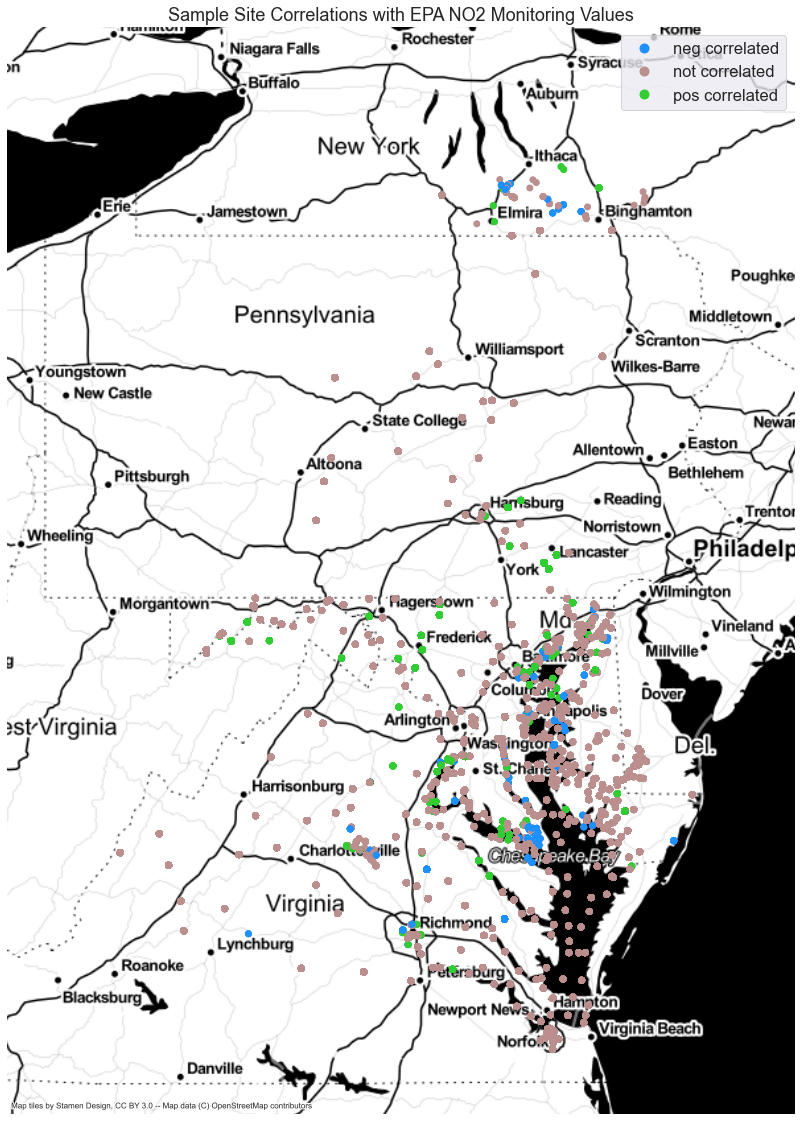

In [101]:

# plot the watershed shape file
ax = base.plot(color = 'white', edgecolor='green',figsize=(20,20), alpha=0)
# add a basemap from contextily
ctx.add_basemap(ax,source=ctx.providers.Stamen.Toner, zoom=7)
# project the geo dataframe to a mercator map format, then plot the sample site locations, colored by correlation
gdf.to_crs(epsg=3857).plot(ax=ax, column='correlated', cmap=ListedColormap(['dodgerblue','rosybrown','limegreen',]),legend=True)

ax.set_title("Sample Site Correlations with EPA NO2 Monitoring Values")
ax.set_axis_off()
plt.show()

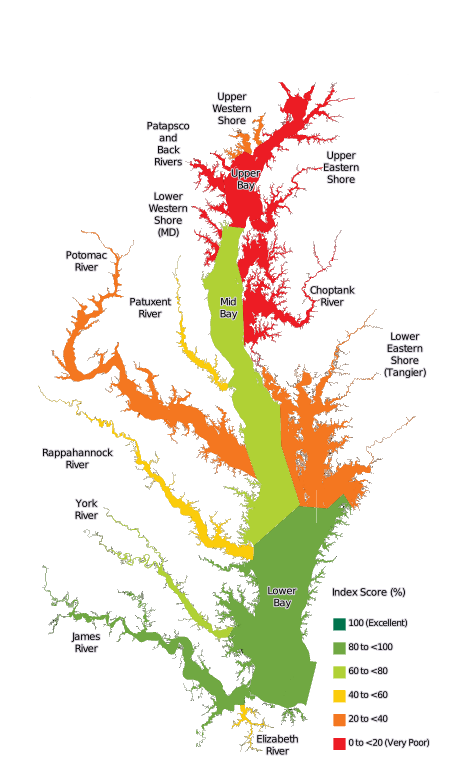 https://ian.umces.edu/ecocheck/report-cards/chesapeake-bay/2013/indicators/total_nitrogen/

Visually from the sample locations that are highly correlated there seem to be many locations that align with Integration & Application Networks's most recent Chesapeake Bay Health (Total Nitrogen Threshold) Indicator Map (2013). 
- There a clumps of sample locations that were correlated with nearby NO2 air monitoring stations that  also showed fair to poor on the 2013 Indicator map, including the Upper Bay (Upper Western Shore, Upper Eastern Shore, Patapsco and Back Rivers), Patuxent River, and Potomac River.
- There mroe clusters of correlated sample locations further away from the bay, in New York, further up the Potomac and Susquehanna rivers. 
- These also seem to be clustered around cities, such as York, Lancaster, Charlottesville and others.
- There does not seem to be many sites correlated with NO2 in the air in the Lower Easter Shore area of the Chesapeake Bay.
- Most in/near the open water of the bay is not correlated with NO2 values
- It appears, with the exception of New York, most of the sample locations that are near the open water of the bay are negatively correlated with the nearby monitoring station. And the positivly correlated sample sites are both near the open water of the bay and further away.

To improve this visualization:
- Including point source locations in the Airshed
- Find and plot sample sites with highly variable values for Total Nitrogen to see how they relate to the sites that are correlated or not correlated
- Some of the values (though, not all for every sample site) were very far away (the max is 100 miles) from the monitoring station due to data sparsity at the closest n stations. Filtering to the most recent data could give a different visualization
- Investigate how weather data plays a role in these correlations. Does rainfall cause NO2 to leave the air, enter the water with a result in a lower NO2 reading? Can the change in that NO2 reading back captured?

In [102]:
# gdf['new_date']=gdf.new_date.astype(str)
# gdf.to_file(os.path.join(PROJ_ROOT, 
#                          'data',
#                         'processed',
#                          'geodf_all_data.shp'))